In [312]:
import tensorboard
%load_ext tensorboard
%tensorboard --logdir 'logs/'
import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.preprocessing import KBinsDiscretizer
# Se importan librerías para graficar.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from keras import backend as K
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input
import keras.regularizers
from tensorflow.keras import optimizers
from sklearn.preprocessing import PolynomialFeatures

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 17008), started 6:35:54 ago. (Use '!kill 17008' to kill it.)

In [313]:
df = pd.read_csv('diabetes.csv')

In [314]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [315]:
healthy_people_num = (df['Outcome'] == 0).sum()
sick_people_num = (df['Outcome'] != 0).sum()
total = df.shape[0]
print("Healthy people: " + str(healthy_people_num))
print("Sick people: " + str(sick_people_num))
print("Total: " + str(total))

Healthy people: 500
Sick people: 268
Total: 768


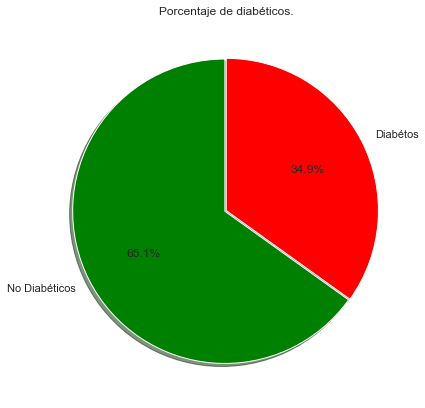

In [316]:
sns.set(style="whitegrid")
labels = ['No Diabéticos', 'Diabétos']
sizes = [healthy_people_num,sick_people_num]
colors = ["green","red"]
plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, explode= (0.01,0) , colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)

plt.title('Porcentaje de diabéticos.')
plt.show()

In [317]:
df2 = df.copy()
df2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

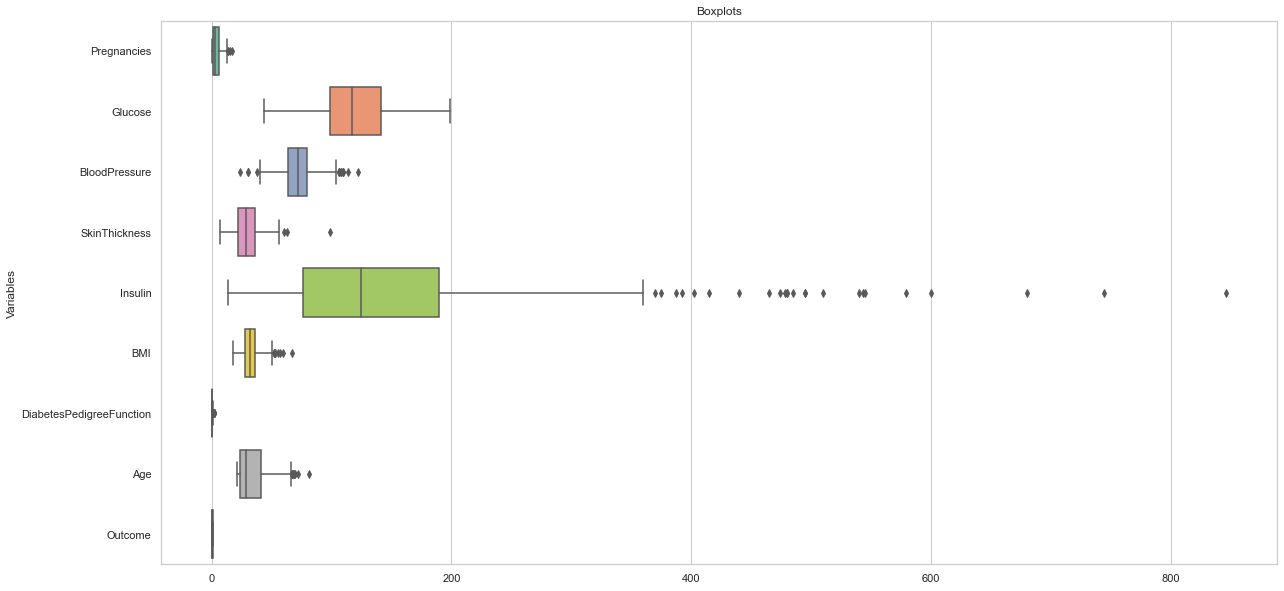

In [318]:
f, ax = plt.subplots(figsize=(20, 10))
plt.ylabel('Variables')
plt.title("Boxplots")
ax = sns.boxplot(data = df2, 
  orient = 'h', 
  palette = 'Set2')

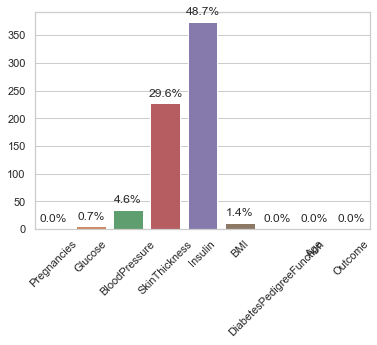

In [319]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=df2.columns, y=df2.isnull().sum())
plt.xticks(rotation=45);
for p in ax.patches:
    ax.annotate(format(100*p.get_height()/df.shape[0], '.1f') + "%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')

In [320]:
correlations = df2.corr()
correlations['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.494650
BMI                         0.313680
Insulin                     0.303454
SkinThickness               0.259491
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
BloodPressure               0.170589
Name: Outcome, dtype: float64

In [321]:
df = df.drop(['Insulin'], axis=1)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,33.6,0.627,50,1
1,1,85,66,29,26.6,0.351,31,0
2,8,183,64,0,23.3,0.672,32,1
3,1,89,66,23,28.1,0.167,21,0
4,0,137,40,35,43.1,2.288,33,1


In [322]:
msk = np.random.rand(len(df)) < 0.9
train_df = df[msk]
test_df = df[~msk]

In [323]:
def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sens_keras = true_positives / (possible_positives + K.epsilon())
    return sens_keras

def positive_predictive_value(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    ppv_keras = true_positives / (predicted_positives + K.epsilon())
    return ppv_keras

In [324]:
def plot_loss(history):
    # Plot the training loss.
    plt.plot(history.history['loss'], 'r-')

    # Plot the validation loss.
    plt.plot(history.history['val_loss'], 'b-')

    # X-axis label.
    plt.xlabel('Epochs')

    # Y-axis label.
    plt.ylabel('Cost')

    # Graph legend.
    plt.legend(["Training loss", "Validation loss"])

    # Graph title.
    plt.title('Loss Graph')

    plt.show()

In [325]:
class DiabetesPredictor:
    def __init__(self, dataframe, name, replaceOutliers=False, deleteRowsWithOutliers=False, replaceNulls=False,deleteRowsWithNulls=False, nullColumns=[], outliersColumns=[], columnsToRemove=[], polyFeatDeg = -1, binsDiscretizer = -1):
        """DiabetesPredictor

    This is a class contains the most part of the methods needed for the diabetes predictor,
    first get the data of the csv file and then perform some methods to clean the data insid
    and allows you to choose if it has to replace outliers or not and replace nulls values or not.


    Attributes:
        replace_outliers: Use the string "replace_outliers" if you want to do that on your model with the median value
        replace_nulls: Use the string "replace_nulls" to replace all nulls in your model with the median value
        delete_row_with_outliers: Use the string "delete_row_with_outliers" to replace all the rows that contains outliers
    """
        self.df = dataframe.copy()
        self.name = name

        nullCols = nullColumns.copy()
        outlierCols = outliersColumns.copy()

        self.__remove_columns__(columnsToRemove)
        for col in columnsToRemove:
            nullCols.remove(col)
            outlierCols.remove(col)

        if (replaceNulls or deleteRowsWithNulls):
            self.df[nullCols] = self.df[nullCols].replace(0,np.NaN)

        if(replaceOutliers):
            self.__replace_outliers__(outlierCols)
        elif(deleteRowsWithOutliers): 
            self.__delete_row_with_outliers__(outlierCols)

        if(replaceNulls):
            self.__replace_nulls__(nullCols)
        elif (deleteRowsWithNulls):
            self.__delete_row_with_nulls__(nullCols)

        self.__separate_data_and_labels__()

        if (polyFeatDeg > 0):
            poly = PolynomialFeatures(degree=polyFeatDeg)
            self.x = poly.fit_transform(self.x)

        if (binsDiscretizer > 1):
            disc = KBinsDiscretizer(n_bins=binsDiscretizer, encode='ordinal', strategy='uniform')
            self.x = disc.fit_transform(self.x)

        self.__normalize_data__()
        self.__split_train_val__()

    def __separate_data_and_labels__(self):
        df_values = self.df.values
        self.x = df_values[:,:-1]
        self.y = df_values[:, -1].reshape(self.x.shape[0], 1)

    def __normalize_data__(self):
        # Mean, columnar axis.
        x_mean = np.mean(self.x, axis=0, keepdims=True)
        # Std. Deviation, columnar axis.
        x_std = np.std(self.x, axis=0, keepdims=True)
        # Normalizing.
        self.x = (self.x - x_mean)/x_std
    
    def __replace_outliers__(self, cols):
        #Para cada columna (excepto para el Outcome) se reemplazan los outliers por su mediana.
        if(cols == []):
            for col in self.df.columns:
                cols.append([col, np.Infinity, 0])
        for col in cols:
            Upper_val, Lower_val, med = self.__get_outliers_limits__(col)
            #Reemplazo.
            for i in self.df[col[0]]:
                if i > Upper_val or i < Lower_val:
                    self.df[col[0]] = self.df[col[0]].replace(i, med)

    def __get_outliers_limits__(self, col, want_med = True):
        #Cálculo de parámetros para obtener los outliers.
        q1 = self.df[col[0]].quantile(0.25)
        q3 = self.df[col[0]].quantile(0.75)
        iqr = q3-q1
        #Límites de los valores tipicos.
        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr

        Lower_val = min(Lower_tail, col[1])
        Upper_val = max(Upper_tail, col[2])
        #Cálculo de la mediana.
        med = np.median(self.df[col[0]])
        if(want_med == True):
            return Upper_val, Lower_val, med
        else:
            return Upper_val, Lower_val

    def __replace_nulls__(self, cols):
        columns = cols
        median=self.df[columns].median()
        self.df[columns]=self.df[columns].replace(np.NaN,median)

    def __remove_columns__(self, cols):
        self.df = self.df.drop(cols, axis=1)
    
    def __split_train_val__(self):
        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self.x, self.y, test_size=0.1, random_state=5)

    def __model_builder__(self,hp):
        model = Sequential()
        initializer = tf.keras.initializers.GlorotNormal(seed=7)
        model.add(Dense(1, kernel_initializer=initializer, activation='sigmoid', input_shape=(self.x.shape[1],)))

        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_momentum = hp.Choice('momentum',values=[0.9, 0.99, 0.999])
        hp_learning_rate = hp.Float('learning_rate', 1e-5, 1.0, sampling='log', default=1e-3)
        

        model.compile(optimizer=optimizers.SGD(momentum=hp_momentum, learning_rate=hp_learning_rate, ),
                        loss=keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.AUC()])

        return model

    def __find_best_hyperparams__(self):
        log_dir = "logs/" + datetime.datetime.now().strftime("%m%d-%H%M")
        hist_callback = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1,
            embeddings_freq=1,
            write_graph=True,
            update_freq='batch')
        self.tuner = kt.Hyperband(self.__model_builder__,
                     kt.Objective("val_loss", direction="min"),
                     max_epochs=20,
                     factor=3,
                     executions_per_trial=3,
                     project_name=self.name,
                     directory='saved_models'
                     )
        self.tuner.search(self.x_train, self.y_train, epochs=100, validation_split=0.2, use_multiprocessing=True)
        self.best_hps=self.tuner.get_best_hyperparameters(num_trials=2)[0]

    def get_best_hyperparams(self):
        return 'Learning Rate: ' + str(self.best_hps.get('learning_rate')) + '   --   Momentum: ' + str(self.best_hps.get('momentum'))

    def train_model(self):
        self.__find_best_hyperparams__()
        model = self.tuner.hypermodel.build(self.best_hps)
        history = model.fit(self.x_train, self.y_train, epochs=100, validation_split=0.2, verbose=0)
        plot_loss(history)
        val_acc_per_epoch = history.history['val_loss']
        best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
        print('Best epoch: %d' % (best_epoch,))
        #plot_loss(history)
        self.hypermodel = self.tuner.hypermodel.build(self.best_hps)
        # Retrain the model
        self.hypermodel.fit(self.x_train, self.y_train, epochs=best_epoch, validation_split=0.2)

    def validate_model(self):
        self.predictions = self.hypermodel(self.x_val)
        self.fpr_keras, self.tpr_keras, self.thresholds_keras = roc_curve(self.y_val, self.predictions)
        self.auc_keras = auc(self.fpr_keras, self.tpr_keras)
        return self.auc_keras

    def plot_roc(self):
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(self.fpr_keras, self.tpr_keras, label='Keras (area = {:.3f})'.format(self.auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()

    def get_metrics(self):
        print('AUC ' + str(self.auc_keras))
        rounded_preds = np.rint(self.predictions)
        print('Specificity: ' + str(specificity(self.y_val.astype(float),  rounded_preds.astype(float))))
        print('Sensitivity: ' + str(sensitivity(self.y_val.astype(float),  rounded_preds.astype(float))))
        print('Positive Predictive Value: ' + str(positive_predictive_value(self.y_val.astype(float), rounded_preds.astype(float))))
        print('Negative Predictive Value: ' + str(negative_predictive_value(self.y_val.astype(float), rounded_preds.astype(float))))
    
    def __delete_row_with_outliers__(self, cols):
        #Para cada columna (excepto para el Outcome) se buscan los outliers para borrar la fila
        if(cols == []):
            for col in self.df.columns:
                cols.append([col, np.Infinity, 0])
        for col in cols:
            Upper_val, Lower_val, med = self.__get_outliers_limits__(col)
            self.df = self.df[(Lower_val < self.df[col[0]]) & (self.df[col[0]] < Upper_val)]

    def __delete_row_with_nulls__(self, cols):
        for col in cols:
            self.df = self.df[pd.notnull(self.df[col])]
        

In [326]:
predictor = DiabetesPredictor(train_df,'predictor')

Trial 30 Complete [00h 00m 17s]
val_loss: 0.4703063468138377

Best val_loss So Far: 0.44666704535484314
Total elapsed time: 00h 06m 49s
INFO:tensorflow:Oracle triggered exit


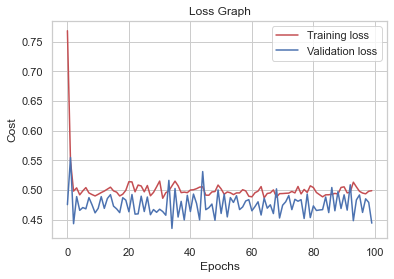

Best epoch: 35
Epoch 1/35
16/16 [==============================] - 4s 88ms/step - loss: 0.6775 - auc: 0.7038 - val_loss: 0.4778 - val_auc: 0.8724
Epoch 2/35
16/16 [==============================] - 0s 9ms/step - loss: 0.5967 - auc: 0.7934 - val_loss: 0.5914 - val_auc: 0.8094
Epoch 3/35
16/16 [==============================] - 0s 5ms/step - loss: 0.5192 - auc: 0.8122 - val_loss: 0.4534 - val_auc: 0.8708
Epoch 4/35
16/16 [==============================] - 0s 5ms/step - loss: 0.4997 - auc: 0.8165 - val_loss: 0.4710 - val_auc: 0.8671
Epoch 5/35
16/16 [==============================] - 0s 6ms/step - loss: 0.4970 - auc: 0.8141 - val_loss: 0.4936 - val_auc: 0.8562
Epoch 6/35
16/16 [==============================] - 0s 7ms/step - loss: 0.4978 - auc: 0.8190 - val_loss: 0.4780 - val_auc: 0.8609
Epoch 7/35
16/16 [==============================] - 0s 6ms/step - loss: 0.5083 - auc: 0.8099 - val_loss: 0.4603 - val_auc: 0.8716
Epoch 8/35
16/16 [==============================] - 0s 8ms/step - loss: 0.

In [286]:
predictor.train_model()

In [287]:
predictor.get_best_hyperparams()

'Learning Rate: 0.1676070289789415   --   Momentum: 0.9'

In [288]:
auc_pred = predictor.validate_model()
print('AUC: ' + str(auc_pred))

AUC: 0.7643784786641931


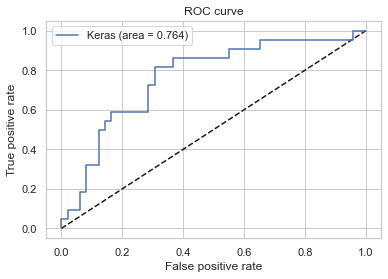

In [289]:
predictor.plot_roc()

In [290]:
predictor.get_metrics()

AUC 0.7643784786641931
Specificity: tf.Tensor(0.7346938760516452, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.5909090882231405, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.4999999980769231, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.7999999982222222, shape=(), dtype=float64)


## Limpiando Datos

#### Reemplazando Nulls por la mediana

In [307]:
predictorRepNulls = DiabetesPredictor(train_df,'rep_nulls_predictor' ,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'])
predictorRepNulls.train_model()
aucRepNulls = predictorRepNulls.validate_model()
print('AUC: ' + str(aucRepNulls))

[[  6.    148.     72.    ...   0.627  50.      1.   ]
 [  1.     85.     66.    ...   0.351  31.      0.   ]
 [  8.    183.     64.    ...   0.672  32.      1.   ]
 ...
 [  5.    121.     72.    ...   0.245  30.      0.   ]
 [  1.    126.     60.    ...   0.349  47.      1.   ]
 [  1.     93.     70.    ...   0.315  23.      0.   ]]

Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
momentum          |0.999             |?                 
learning_rate     |0.038434          |?                 
tuner/epochs      |3                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |2                 |?                 
tuner/round       |0                 |?                 

Epoch 1/3
16/16 [==============================] - 2s 41ms/step - loss: 0.8342 - auc: 0.5683 - val_loss: 0.4513 - val_auc: 0.8773
Epoch 2/3
16/16 [==============================] - 0s 4ms/step - loss: 0.7360 - auc: 0.7938 - val_loss: 0.7

KeyboardInterrupt: 

In [292]:
predictorRepNulls.get_best_hyperparams()

'Learning Rate: 0.7973509929520485   --   Momentum: 0.9'

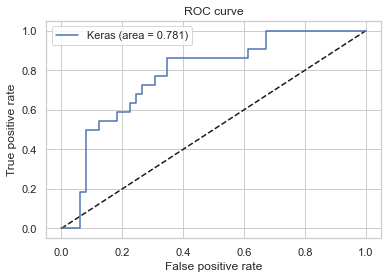

AUC 0.7810760667903525
Specificity: tf.Tensor(0.755102039275302, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.6363636334710744, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.5384615363905325, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8222222203950618, shape=(), dtype=float64)


In [293]:
predictorRepNulls.plot_roc()
predictorRepNulls.get_metrics()

#### Removiendo Nulls

In [310]:
predictorRemNulls = DiabetesPredictor(train_df,'rem_nulls_predictor' ,deleteRowsWithNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'])
predictorRemNulls.train_model()
aucRemNulls = predictorRemNulls.validate_model()
print('AUC: ' + str(aucRemNulls))

Trial 13 Complete [00h 00m 12s]
val_loss: 0.5225932200749716

Best val_loss So Far: 0.5222882231076559
Total elapsed time: 00h 02m 31s

Search: Running Trial #14

Hyperparameter    |Value             |Best Value So Far 
momentum          |0.999             |0.99              
learning_rate     |0.088552          |0.020158          
tuner/epochs      |7                 |3                 
tuner/initial_e...|3                 |0                 
tuner/bracket     |2                 |2                 
tuner/round       |1                 |0                 
tuner/trial_id    |5883417efa6937b...|None              

Epoch 4/7


KeyboardInterrupt: 

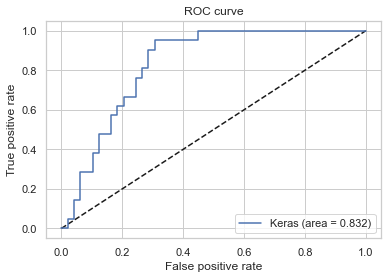

AUC 0.8318756073858113
Specificity: tf.Tensor(0.8163265289462723, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.5714285687074829, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.5714285687074829, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8163265289462723, shape=(), dtype=float64)


In [240]:
predictorRemNulls.plot_roc()
predictorRemNulls.get_metrics()

#### Removiendo Outliers

Trial 30 Complete [00h 00m 15s]
val_loss: 0.8051496346791586

Best val_loss So Far: 0.49225789308547974
Total elapsed time: 00h 04m 31s
INFO:tensorflow:Oracle triggered exit


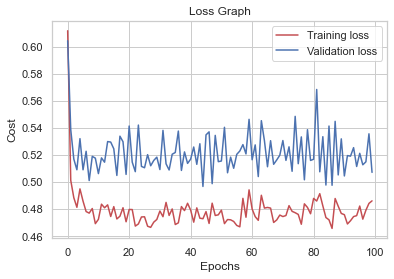

Best epoch: 45
Epoch 1/45
14/14 [==============================] - 2s 48ms/step - loss: 0.6558 - auc: 0.6959 - val_loss: 0.5910 - val_auc: 0.7487
Epoch 2/45
14/14 [==============================] - 0s 4ms/step - loss: 0.5260 - auc: 0.8395 - val_loss: 0.5696 - val_auc: 0.7810
Epoch 3/45
14/14 [==============================] - 0s 4ms/step - loss: 0.4811 - auc: 0.8333 - val_loss: 0.5208 - val_auc: 0.7757
Epoch 4/45
14/14 [==============================] - 0s 4ms/step - loss: 0.4815 - auc: 0.8237 - val_loss: 0.5269 - val_auc: 0.7729
Epoch 5/45
14/14 [==============================] - 0s 6ms/step - loss: 0.4830 - auc: 0.8405 - val_loss: 0.5305 - val_auc: 0.7593
Epoch 6/45
14/14 [==============================] - 0s 4ms/step - loss: 0.4821 - auc: 0.8324 - val_loss: 0.5181 - val_auc: 0.7863
Epoch 7/45
14/14 [==============================] - 0s 4ms/step - loss: 0.4676 - auc: 0.8439 - val_loss: 0.5254 - val_auc: 0.7593
Epoch 8/45
14/14 [==============================] - 0s 4ms/step - loss: 0.

In [241]:
predictorRemOutliers = DiabetesPredictor(train_df,'rem_outliers_predictor' ,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], deleteRowsWithOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120],['SkinThickness', np.Infinity, 0], ['Pregnancies',np.Infinity,0]])
predictorRemOutliers.train_model()
aucRemOut = predictorRemOutliers.validate_model()
print('AUC: ' + str(aucRemOut))

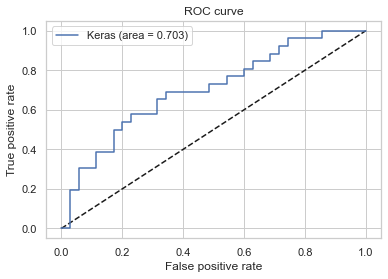

AUC 0.7032967032967034
Specificity: tf.Tensor(0.7714285692244898, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.576923074704142, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6521739102079395, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.7105263139196676, shape=(), dtype=float64)


In [242]:
predictorRemOutliers.plot_roc()
predictorRemOutliers.get_metrics()

#### Reemplazando Outliers

Trial 30 Complete [00h 00m 12s]
val_loss: 0.6234027544657389

Best val_loss So Far: 0.5420013864835104
Total elapsed time: 00h 04m 53s
INFO:tensorflow:Oracle triggered exit


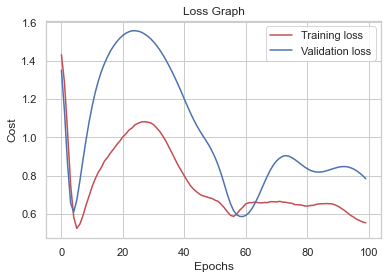

Best epoch: 60
Epoch 1/60
16/16 [==============================] - 2s 38ms/step - loss: 0.9549 - auc: 0.4302 - val_loss: 0.9301 - val_auc: 0.4914
Epoch 2/60
16/16 [==============================] - 0s 4ms/step - loss: 0.8772 - auc: 0.4718 - val_loss: 0.8132 - val_auc: 0.5645
Epoch 3/60
16/16 [==============================] - 0s 4ms/step - loss: 0.7499 - auc: 0.5689 - val_loss: 0.6743 - val_auc: 0.6750
Epoch 4/60
16/16 [==============================] - 0s 4ms/step - loss: 0.6202 - auc: 0.7047 - val_loss: 0.5767 - val_auc: 0.7496
Epoch 5/60
16/16 [==============================] - 0s 4ms/step - loss: 0.5360 - auc: 0.7936 - val_loss: 0.5566 - val_auc: 0.7646
Epoch 6/60
16/16 [==============================] - 0s 4ms/step - loss: 0.4938 - auc: 0.8279 - val_loss: 0.6029 - val_auc: 0.7588
Epoch 7/60
16/16 [==============================] - 0s 4ms/step - loss: 0.5003 - auc: 0.8362 - val_loss: 0.6860 - val_auc: 0.7569
Epoch 8/60
16/16 [==============================] - 0s 4ms/step - loss: 0.

In [243]:
predictorRepOutliers = DiabetesPredictor(train_df,'rep_outliers_predictor' ,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], replaceOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120], ['Pregnancies',np.Infinity,0]])
predictorRepOutliers.train_model()
aucRepOut = predictorRepOutliers.validate_model()
print('AUC: ' + str(aucRepOut))

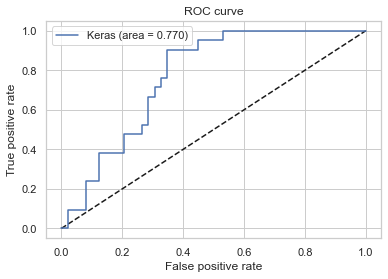

AUC 0.7696793002915452
Specificity: tf.Tensor(0.7959183657226155, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.42857142653061225, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.47368420803324096, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.7647058808535179, shape=(), dtype=float64)


In [244]:
predictorRepOutliers.plot_roc()
predictorRepOutliers.get_metrics()

#### Removiendo Columnas

Trial 30 Complete [00h 00m 19s]
val_loss: 0.462832510471344

Best val_loss So Far: 0.44180487593015033
Total elapsed time: 00h 06m 20s
INFO:tensorflow:Oracle triggered exit


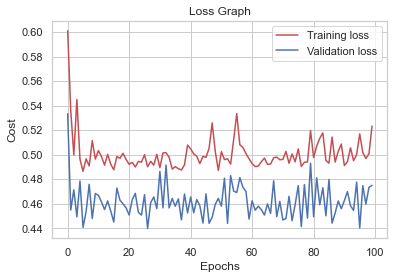

Best epoch: 27
Epoch 1/27
18/18 [==============================] - 2s 32ms/step - loss: 0.5238 - auc: 0.8064 - val_loss: 0.4892 - val_auc: 0.8515
Epoch 2/27
18/18 [==============================] - 0s 5ms/step - loss: 0.5101 - auc: 0.8222 - val_loss: 0.4544 - val_auc: 0.8613
Epoch 3/27
18/18 [==============================] - 0s 4ms/step - loss: 0.4925 - auc: 0.8283 - val_loss: 0.4813 - val_auc: 0.8342
Epoch 4/27
18/18 [==============================] - 0s 6ms/step - loss: 0.4984 - auc: 0.8241 - val_loss: 0.4454 - val_auc: 0.8645
Epoch 5/27
18/18 [==============================] - 0s 4ms/step - loss: 0.4991 - auc: 0.8170 - val_loss: 0.4575 - val_auc: 0.8531
Epoch 6/27
18/18 [==============================] - 0s 6ms/step - loss: 0.4912 - auc: 0.8265 - val_loss: 0.4690 - val_auc: 0.8445
Epoch 7/27
18/18 [==============================] - 0s 9ms/step - loss: 0.5078 - auc: 0.8190 - val_loss: 0.4434 - val_auc: 0.8618
Epoch 8/27
18/18 [==============================] - 0s 6ms/step - loss: 0.

In [250]:
bestAuc = aucRepNulls
tryRemovingCols = ['BloodPressure', 'Age', 'DiabetesPedigreeFunction', 'Pregnancies', 'SkinThickness']
removeCols = []
removeColsAuc = []
nullCols = ['Glucose','BloodPressure','SkinThickness','BMI']

for col in tryRemovingCols:
    print(col)
	pred = DiabetesPredictor(df,col ,replaceNulls=True, nullColumns=nullCols, columnsToRemove=[col])
	pred.train_model()
	aucR = pred.validate_model()
	if (aucR>bestAuc):
		removeCols.append(col)
        removeColsAuc.append(aucR)



In [251]:
print(removeCols)

['BloodPressure', 'Age', 'DiabetesPedigreeFunction', 'SkinThickness']


Trial 30 Complete [00h 00m 19s]
val_loss: 0.5838766892751058

Best val_loss So Far: 0.45565574367841083
Total elapsed time: 00h 07m 02s
INFO:tensorflow:Oracle triggered exit


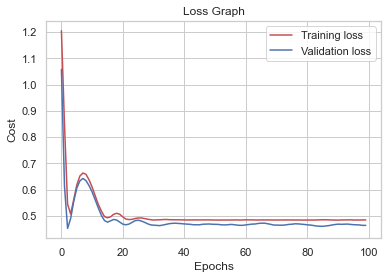

Best epoch: 3
Epoch 1/3
18/18 [==============================] - 3s 54ms/step - loss: 0.6863 - auc: 0.6750 - val_loss: 0.6350 - val_auc: 0.6730
Epoch 2/3
18/18 [==============================] - 0s 4ms/step - loss: 0.5956 - auc: 0.7384 - val_loss: 0.5301 - val_auc: 0.7807
Epoch 3/3
18/18 [==============================] - 0s 4ms/step - loss: 0.5022 - auc: 0.8161 - val_loss: 0.4746 - val_auc: 0.8415


In [254]:
finalPred = DiabetesPredictor(df,'final' ,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'],  columnsToRemove=removeCols)
finalPred.train_model()
aucFinal = finalPred.validate_model()

In [255]:
print('AUC: ' + str(aucFinal))

AUC: 0.8679245283018868


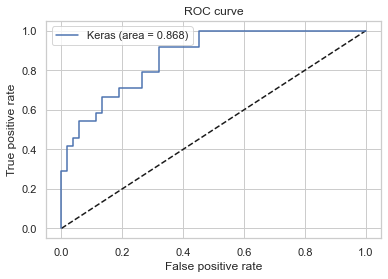

AUC 0.8679245283018868
Specificity: tf.Tensor(0.8490566021715913, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.6666666638888888, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6666666638888888, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8490566021715913, shape=(), dtype=float64)


In [256]:
finalPred.plot_roc()
finalPred.get_metrics()